# import

In [1]:
import numpy as np
import os
from gaussian.calculation_checker import check_from_logfile
from gaussian.load_calc_result import LoadCalcResultFromLogFile
from gaussian.search_logs import SearchLogFromKeywords
from dataframe.load import load_csv
from smiles.change_format import gen_alt_smiles
from tqdm.notebook import tqdm

## BDE calculation

In [2]:
DF_PATH = "./data/oximesters.csv"
# folder you calculated compounds using gaussian
BASE_DIR = "/Volumes/buffalow_volume/oximesters/oxims"

In [3]:
df = load_csv(DF_PATH)
df.head()

,Smiles,acetoxy_radical,iminyl_radical,free_radical
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1


In [4]:
print(len(df['Smiles']), len(df['Smiles'].unique()))

299 286


In [5]:
df_BDE = df.copy()
BDEs = []
ERRORS = []
searcher = SearchLogFromKeywords(keywords=['freq'], base_dir=BASE_DIR)
ac_ens = []
n_ens = []
imi_ens = []
for i in tqdm(range(len(df))):
    target_row = df.iloc[i]
    neutral = target_row['Smiles']
    acetoxy_rad = target_row['acetoxy_radical']
    iminyl_rad = target_row['iminyl_radical']

    objects = [neutral, acetoxy_rad, iminyl_rad]

    cache_en = []
    for i, obj in enumerate(objects):
        log_path = searcher.search(obj)
        if log_path:
            # input into the list if it is normal frequencies
            log_path = os.path.join(BASE_DIR, log_path)
            loader = LoadCalcResultFromLogFile(log_path)
            if loader.is_normal_frequencies() and loader.is_ended_normally():
                #en = loader.get_GibbsFreeEnergy()
                en = loader.get_Enthalpy()
                cache_en.append(en)
    if len(cache_en) == 3:
        BDE = - (cache_en[0] - (cache_en[1] + cache_en[2])) * 627.51
    else:
        for obj in objects:
            log_path = searcher.search(obj)
            calc_result = check_from_logfile(log_path, detect_normal_freq=True)
            if calc_result != 'Success':
                ERRORS.append([obj, 'BDE_freq', calc_result])
        BDE = None
    BDEs.append(BDE)
df_BDE['BDE'] = BDEs
df_BDE.head()

  0%|          | 0/299 [00:00<?, ?it/s]

,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.731548
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418


In [6]:
df_BDE = df_BDE.dropna()
df_BDE

,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.731548
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418
...,...,...,...,...,...
294,CC(=O)O/N=C1\CC2C3CCC([C@H](C)CCCC(C)C)C3(C)CC...,CC([O])=O,CC(=O)OC1CCC2(C)C3CCC4(C)C(CCC4[C@H](C)CCCC(C)...,[C],50.919299
295,CC(C)=NOC(=O)CNC(=O)OCc1ccccc1,[O]C(=O)CNC(=O)OCc1ccccc1,CC(C)=[N],[C]NC(=O)OCc1ccccc1,46.044801
296,[2H][13C]([2H])([2H])N[13C](=O)O/N=C/C(C)(C)S(...,[2H][13C]([2H])([2H])N[13C]([O])=O,CS(=O)C(C)(C)C=[N],[2H][13C]([2H])([2H])[NH],43.932603
297,[2H][13C]([2H])([2H])N[13C](=O)O/N=C/C(C)(C)SC,[2H][13C]([2H])([2H])N[13C]([O])=O,CSC(C)(C)C=[N],[2H][13C]([2H])([2H])[NH],42.307352


<AxesSubplot:>

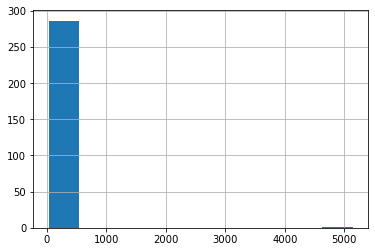

In [8]:
# BDEが30未満のものはアセトキシラジカルが壊れている可能性がある
df_might = df_BDE[(40 > df_BDE['BDE'])|(df_BDE['BDE'] > 60)]
print(len(df_might))
df_might.head()

27


,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE
9,O=C(Nc1ccc(F)cc1)ON=C1CCCCC1,[O]C(=O)Nc1ccc(F)cc1,[N]=C1CCCCC1,[NH]c1ccc(F)cc1,38.679089
17,CC(C)=NOC(=O)Nc1ccc(Cc2ccc(NC(=O)ON=C(C)C)cc2)cc1,CC(C)=NOC(=O)Nc1ccc(Cc2ccc(NC([O])=O)cc2)cc1,CC(C)=[N],[NH]c1ccc(Cc2ccc(NC(=O)ON=C(C)C)cc2)cc1,25.414783
19,Cc1cccc(NC(=O)ON=C2CCCCC2)c1,Cc1cccc(NC([O])=O)c1,[N]=C1CCCCC1,[NH]c1cccc(C)c1,38.274972
33,Cc1cccc(Cl)c1NC(=O)ON=C1CCCCC1,Cc1cccc(Cl)c1NC([O])=O,[N]=C1CCCCC1,[NH]c1c(C)cccc1Cl,38.280620
41,COc1cc(C)ccc1NC(=O)ON=C(C)C,COc1cc(C)ccc1NC([O])=O,CC(C)=[N],[NH]c1ccc(C)cc1OC,5143.532552


In [8]:
# BDEが30未満のものはアセトキシラジカルが壊れている可能性がある
df_BDE = df_BDE[(30 < df_BDE['BDE'])&(df_BDE['BDE'] < 50)]
print(len(df_BDE))
df_BDE.head()

282


,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.731548
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418


<AxesSubplot:>

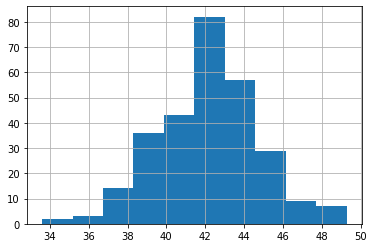

In [9]:
df_BDE['BDE'].hist()

In [10]:
# 壊れている構造は削除
breaking = []
for rad in df_BDE['acetoxy_radical'].unique():
    log_path = searcher.search(rad)
    loader = LoadCalcResultFromLogFile(log_path)
    if not loader.is_not_breaking():
        breaking.append(rad)
for s in breaking:
    df_BDE = df_BDE[df_BDE['acetoxy_radical'] != s]
print(len(df_BDE))
df_BDE.head()

257


,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.731548
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418


In [11]:
print(breaking)

[]


In [12]:
df_BDE.to_csv('./data/oximesters_BDE.csv')

In [15]:
print(ERRORS)

[['[O]C(=O)Nc1cccc2ccccc12', 'BDE_freq', 'Imaginary Frequencies!!'], ['[O]C(=O)Nc1cccc2ccccc12', 'BDE_freq', 'Imaginary Frequencies!!'], ['COc1ccc(NC([O])=O)cc1', 'BDE_freq', 'Calculation Failed!!'], ['COc1cccc(NC([O])=O)c1', 'BDE_freq', 'Calculation Failed!!'], ['COc1cccc(NC([O])=O)c1', 'BDE_freq', 'Calculation Failed!!'], ['Cc1ccc(NC([O])=O)cc1', 'BDE_freq', 'Calculation Failed!!'], ['Cc1ccc(NC([O])=O)cc1', 'BDE_freq', 'Calculation Failed!!'], ['[O]C(=O)Nc1cccc2ccccc12', 'BDE_freq', 'Imaginary Frequencies!!'], ['[O]C(=O)Nc1cccc2c(NC(=O)ON=C3CCCCC3)cccc12', 'BDE_freq', 'Calculation Failed!!'], ['COc1ccc(NC([O])=O)cc1', 'BDE_freq', 'Calculation Failed!!'], ['[O]C(=O)Nc1ccc(Cc2ccc(NC(=O)ON=C3CCCCC3)cc2)cc1', 'BDE_freq', 'Calculation Failed!!'], ['CC(=O)O/N=C1/c2ccccc2-c2ccc(I)cc21', 'BDE_freq', 'Calculation Failed!!'], ['[N]=C1c2ccccc2-c2ccc(I)cc21', 'BDE_freq', 'Calculation Failed!!']]


# 吸収特性のラベル付け

In [1]:
import numpy as np
import os
from gaussian.calculation_checker import check_from_logfile
from gaussian.load_calc_result import LoadCalcResultFromLogFile
from gaussian.search_logs import SearchLogFromKeywords
from dataframe.load import load_csv
from smiles.change_format import gen_alt_smiles
from files.extension import ExtensionChanger
from tqdm.notebook import tqdm
import shutil

In [2]:
DF_PATH = "./data/oximesters.csv"
# folder you calculated compounds using gaussian
BASE_DIR = "/Volumes/buffalow_volume/oximesters/oxims"

In [3]:
df = load_csv(DF_PATH)
df.head()

,Smiles,acetoxy_radical,iminyl_radical,free_radical
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1


In [6]:
labels = []
ERRORS = []
searcher = SearchLogFromKeywords(keywords=['cam-b3lyp'], base_dir=BASE_DIR)
searcher_second = SearchLogFromKeywords(keywords=['freq', 'b3lyp'], base_dir=BASE_DIR)
chks = []
MOVE_TO = '/Volumes/buffalow_volume/chache'
for i in tqdm(range(len(df))):
    smiles = df.iloc[i]['Smiles']
    log_path = searcher.search(smiles)
    if log_path:
        loader = LoadCalcResultFromLogFile(log_path)
        changer = ExtensionChanger(log_path)
        chk_path = changer.replacer('.chk')
        move_to = os.path.join(MOVE_TO, os.path.basename(chk_path))
        if os.path.exists(chk_path):
            shutil.copy(chk_path, move_to)
        else:
            log_opt = searcher_second.search(smiles)
            chk_changer = ExtensionChanger(log_opt)
            chk_path = chk_changer.replacer('.chk')
            shutil.copy(chk_path, os.path.join(MOVE_TO, os.path.basename(chk_path)))
        if loader.osc_strength_range(search_range=(320, 450)):
            labels.append(int(1))
        else:
            labels.append(int(0))
    else:
        log_path = searcher.search(smiles)
        calc_result = check_from_logfile(log_path)
        if calc_result != 'Success':
            ERRORS.append([smiles, 'Spectra', calc_result])
        labels.append(None)
df_spec = df.copy()
df_spec['absorbance_label'] = labels

  0%|          | 0/299 [00:00<?, ?it/s]

In [5]:
df_spec.head()

,Smiles,acetoxy_radical,iminyl_radical,free_radical,absorbance_label
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,0.0
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,0.0
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,0.0
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,0.0
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,0.0


In [6]:
df_spec = df_spec.dropna()
print(len(df_spec))

252


In [9]:
ERRORS

[['O=C(Nc1cccc2ccccc12)ON=C1CCCCC1', 'Spectra', 'File Not Found!!'],
 ['O=C(Nc1cccc2ccccc12)ON=C1c2ccccc2-c2ccccc21',
  'Spectra',
  'File Not Found!!'],
 ['COc1ccc(NC(=O)ON=C(C)C)cc1', 'Spectra', 'File Not Found!!'],
 ['CC(C)=NOC(=O)Nc1ccc(Cc2ccc(NC(=O)ON=C(C)C)cc2)cc1',
  'Spectra',
  'File Not Found!!'],
 ['COc1cccc(NC(=O)ON=C(C)C)c1', 'Spectra', 'File Not Found!!'],
 ['COc1cc(C)ccc1NC(=O)ON=C(C)C', 'Spectra', 'File Not Found!!'],
 ['COc1cccc(NC(=O)ON=C2CCCCC2)c1', 'Spectra', 'File Not Found!!'],
 ['CC(C)=NOC(=O)Nc1ccc([N+](=O)[O-])cc1C', 'Spectra', 'File Not Found!!'],
 ['Cc1ccc(NC(=O)ON=C2CCCCC2)cc1', 'Spectra', 'File Not Found!!'],
 ['CC(C)=NOC(=O)Nc1ccc(C)cc1', 'Spectra', 'File Not Found!!'],
 ['CC(C)=NOC(=O)Nc1cccc2ccccc12', 'Spectra', 'File Not Found!!'],
 ['O=C(Nc1cccc2c(NC(=O)ON=C3CCCCC3)cccc12)ON=C1CCCCC1',
  'Spectra',
  'File Not Found!!'],
 ['COc1ccc(NC(=O)ON=C2CCCCC2)cc1', 'Spectra', 'File Not Found!!'],
 ['CC(C)=NOC(=O)Nc1c(C)cccc1C', 'Spectra', 'File Not Found!!'],
 [

In [7]:
df_spec.to_csv('./data/oxims_absorbance_labels.csv')

## スペクトルの取得

### 計算の参考先：https://gaussian.com/uvvisplot/　

In [16]:
df_spec = df_BDE.copy()
integrals = []
searcher = SearchLogFromKeywords(keywords=['excited'], base_dir=BASE_DIR)
for i in tqdm(range(len(df_spec))):
    smiles = df_spec.iloc[i]['Smiles']
    log_path = searcher.search(smiles)
    if log_path:
        log_loader = LoadCalcResultFromLogFile(log_path)
        # get spectra
        df_gen = log_loader.UV_spectra()
        integral = log_loader.spectra_integration()
        integrals.append(integral)
        # save spectra to dataframe
        path = os.path.join(BASE_DIR, gen_alt_smiles(smiles))
        df_gen.to_csv(path + '.csv')
    else:
        log_path = searcher.search(smiles)
        calc_result = check_from_logfile(log_path)
        if calc_result != 'Success':
            ERRORS.append([smiles, 'Spectra', calc_result])
        integrals.append(None)
df_spec['integral'] = integrals
log10_integrals = []
for integral in integrals:
    if integral:
        log10_integrals.append(np.log10(integral))
    else:
        log10_integrals.append(None)
df_spec['log_integral'] = log10_integrals

  0%|          | 0/255 [00:00<?, ?it/s]

In [17]:
df_spec = df_spec.dropna()
df_spec = df_spec.reset_index(drop=True)
df_spec

,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE,integral,log_integral
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053,2.584660e-09,-8.587597
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.730921,1.535691e-01,-0.813696
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142,3.333232e+00,0.522865
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949,3.582803e+00,0.554223
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418,3.891279e-01,-0.409908
...,...,...,...,...,...,...,...
250,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],49.998114,4.609850e+05,5.663687
251,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],45.234686,4.609850e+05,5.663687
252,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],45.242216,5.103210e+05,5.707843
253,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],44.153486,5.103210e+05,5.707843


## calculate decarboxydation enthalpies

In [18]:
import os
from dataframe.load import load_csv
from gaussian.load_calc_result import LoadCalcResultFromLogFile
from smiles.change_format import gen_alt_smiles

In [19]:
CO2_log_path = "/Users/watanabeyuuya/OneDrive - 横浜国立大学/五東研究室/研究/datasets/oximesters/CO2/C(=O)=O_ground_#_freq_b3lyp_6-31G(d)_guess=read_geom=allcheck.log"

In [20]:
df_de = df_spec.copy()
ens = []
# get CO2's enthalpy
CO2_en = LoadCalcResultFromLogFile(CO2_log_path).get_Enthalpy()
searcher = SearchLogFromKeywords(keywords=['freq'], base_dir=BASE_DIR)
for i in tqdm(range(len(df_spec))):
    target = df.iloc[i]
    acetoxy_rad = target['acetoxy_radical']
    free_rad = target['free_radical']

    ### acetoxy radical's enthalpy
    log_path_act = searcher.search(acetoxy_rad)
    loader = LoadCalcResultFromLogFile(log_path_act)
    en_act_rad = loader.get_Enthalpy() if loader.is_normal_frequencies() else None

    ### free radical's enthalpy
    log_path_free = searcher.search(free_rad)
    loader = LoadCalcResultFromLogFile(log_path_free)
    en_free_rad = loader.get_Enthalpy() if loader.is_normal_frequencies() else None

    if en_act_rad and en_free_rad: # BDE calculation
        enthalpy = - (en_act_rad - (en_free_rad + CO2_en)) * 627.51
        ens.append(enthalpy)
    else: # out put Error reason
        smiles_cahche = [acetoxy_rad, free_rad]
        print('')
        print('-----------------------------------------')
        print('Reason of Error...')
        print('Acetoxy Radical {}: {}'.format(acetoxy_rad, check_from_logfile(log_path_act, detect_normal_freq=True)))
        print('Free Radical {}: {}'.format(free_rad, check_from_logfile(log_path_free, detect_normal_freq=True)))
        print('-----------------------------------------')
        print('')
        for s in smiles_cahche:
            log_path = searcher.search(s)
            calc_result = check_from_logfile(log_path, detect_normal_freq=True)
            if calc_result != 'Success':
                ERRORS.append([obj, 'decarboxylation_enthalpy', calc_result])
        ens.append(None)
df_de['decarboxylation_enthalpy'] = ens
df_de

  0%|          | 0/255 [00:00<?, ?it/s]


-----------------------------------------
Reason of Error...
Acetoxy Radical [O]C(=O)Nc1cccc2ccccc12: Imaginary Frequencies!!
Free Radical [NH]c1cccc2ccccc12: Success
-----------------------------------------


-----------------------------------------
Reason of Error...
Acetoxy Radical [O]C(=O)Nc1cccc2ccccc12: Imaginary Frequencies!!
Free Radical [NH]c1cccc2ccccc12: Success
-----------------------------------------


-----------------------------------------
Reason of Error...
Acetoxy Radical COc1ccc(NC([O])=O)cc1: Calculation Failed!!
Free Radical [NH]c1ccc(OC)cc1: Success
-----------------------------------------


-----------------------------------------
Reason of Error...
Acetoxy Radical CC(C)c1cccc(C(C)C)c1NC([O])=O: Success
Free Radical [NH]c1c(C(C)C)cccc1C(C)C: Imaginary Frequencies!!
-----------------------------------------


-----------------------------------------
Reason of Error...
Acetoxy Radical COc1cccc(NC([O])=O)c1: Calculation Failed!!
Free Radical [NH]c1cccc(OC)c1

,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE,integral,log_integral,decarboxylation_enthalpy
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053,2.584660e-09,-8.587597,6.047941
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.730921,1.535691e-01,-0.813696,-14.966113
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142,3.333232e+00,0.522865,-15.872238
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949,3.582803e+00,0.554223,-15.983307
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418,3.891279e-01,-0.409908,-15.272966
...,...,...,...,...,...,...,...,...
250,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],49.998114,4.609850e+05,5.663687,-8.498368
251,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],45.234686,4.609850e+05,5.663687,-8.498368
252,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],45.242216,5.103210e+05,5.707843,-8.498368
253,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],44.153486,5.103210e+05,5.707843,-8.498368


In [13]:
from smiles.prop import is_radical
rad_errors = []
neutral_errors = []
for e in ERRORS:
    smiles = e[0]
    if is_radical(smiles) and smiles not in rad_errors:
        rad_errors.append(smiles)
    elif not is_radical(smiles) and smiles not in neutral_errors:
        neutral_errors.append(smiles)
    else:
        pass

In [16]:
neutral_errors

['CC(C)=NOC(=O)Nc1cccc(C)c1',
 'O=C(Nc1cccc2ccccc12)ON=C1c2ccccc2-c2ccccc21',
 'Cc1cccc(NC(=O)ON=C2CCCCC2)c1',
 'CC(C)=NOC(=O)OCc1ccccc1',
 'Cc1ccc(NC(=O)ON=C2CCCCC2)c(C)c1',
 'CC(C)=NOC(=O)Nc1cc(C)cc(C)c1',
 'Cc1ccc(C)c(NC(=O)ON=C2CCCCC2)c1',
 'Cc1ccc(NC(=O)ON=C2CCCCC2)cc1',
 'CC(C)=NOC(=O)Nc1cccc2ccccc12',
 'CC(C)=NOC(=O)Nc1cc(C(F)(F)F)ccc1Cl',
 'CC(C)=NOC(=O)Nc1cc(C)ccc1C',
 'CC(=O)Nc1ccc(/C=N\\OC(C)=O)cc1',
 'O=C(Nc1ccccc1)O/N=C/c1ccc2c(c1)OCO2',
 'COc1ccccc1NC(=O)O/N=C/c1cccc(C)n1',
 'O=C(Nc1cccc(C(F)(F)F)c1)O/N=C/c1ccc2c(c1)OCO2',
 'O=C(Nc1ccc(Cl)c(Cl)c1)O/N=C/c1ccc2c(c1)OCO2',
 'c1cccc(c12)C(=O)N(C2=O)Cc3ccc(cc3)/C(CC)=N\\OC(=O)C',
 'c1cccc(c12)C(CCCC)(CCCC)c3c2ccc(c3)C(=O)/C(=N\\OC(=O)C)C(=O)c4ccccc4',
 'CC(=O)O/N=C(/C)c(cc1)cc(c12)c3c(n2CC)ccc(c3)C(=O)c4c(C)cccc4']

In [23]:
df_de = df_de.dropna()
df_de = df_de.reset_index(drop=True)
df_de

,Smiles,acetoxy_radical,iminyl_radical,free_radical,BDE,integral,log_integral,decarboxylation_enthalpy
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,41.420053,2.584660e-09,-8.587597,6.047941
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,42.730921,1.535691e-01,-0.813696,-14.966113
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,43.411142,3.333232e+00,0.522865,-15.872238
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,44.487949,3.582803e+00,0.554223,-15.983307
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,43.636418,3.891279e-01,-0.409908,-15.272966
...,...,...,...,...,...,...,...,...
212,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],49.998114,4.609850e+05,5.663687,-8.498368
213,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/C(...,[C],45.234686,4.609850e+05,5.663687,-8.498368
214,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],45.242216,5.103210e+05,5.707843,-8.498368
215,O=C(C)O\N=C(CC)\C(=O)c(cc1)cc(c12)Sc3c(N2CCCCC...,CC([O])=O,CCCCCCCCN1c2ccc(C(=O)C(=[N])CC)cc2Sc2cc(C(=O)/...,[C],44.153486,5.103210e+05,5.707843,-8.498368


In [24]:
df_de.to_csv('./data/oximesters_calcuated.csv')

In [ ]:
errors = []
for error in ERRORS:
    if error not in errors:
        errors.append(error)
errors

In [ ]:
with open('/Users/watanabeyuuya/OneDrive - 横浜国立大学/五東研究室/研究/datasets/oximesters/oxims/errors.pickle', 'wb') as f:
    import pickle
    pickle.dump(errors, f)

# T1 energy

## imports

In [5]:
import os, sys
from tqdm.notebook import tqdm
from dataframe.load import load_csv
from gaussian.load_calc_result import LoadCalcResultFromLogFile
from gaussian.search_logs import SearchLogFromKeywords

## get calculation result

In [6]:
BASE_DIR = '/Volumes/buffalow_volume/oximesters/triplets'
df_path = './data/oximesters.csv'

In [7]:
df = load_csv(df_path)
print(len(df))
df.head()

299


,Smiles,acetoxy_radical,iminyl_radical,free_radical
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1


In [9]:
searcher = SearchLogFromKeywords(keywords=['triplets'], base_dir=BASE_DIR)
smiles = df['Smiles'].values.tolist()
T1s = []
errors = []
for s in tqdm(smiles):
    log = searcher.search(s)
    if log:
        loader = LoadCalcResultFromLogFile(log)
        triplets = loader.triplets()
        T1 = triplets['energy'][0]
        T1s.append(T1)
    else:
        T1s.append(None)
df_t1 = df.copy()
df_t1['T1'] = T1s
print(len(df_t1))
df_t1.head()

  0%|          | 0/299 [00:00<?, ?it/s]

299


,Smiles,acetoxy_radical,iminyl_radical,free_radical,T1
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,4.0425
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,3.4365
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,3.3386
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,3.3086
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,3.3682


In [10]:
df_t1[df_t1['T1'].isnull()]

,Smiles,acetoxy_radical,iminyl_radical,free_radical,T1
6,O=C(Nc1cccc2ccccc12)ON=C1CCCCC1,[O]C(=O)Nc1cccc2ccccc12,[N]=C1CCCCC1,[NH]c1cccc2ccccc12,NaN
14,O=C(Nc1cccc2ccccc12)ON=C1c2ccccc2-c2ccccc21,[O]C(=O)Nc1cccc2ccccc12,[N]=C1c2ccccc2-c2ccccc21,[NH]c1cccc2ccccc12,NaN
16,COc1ccc(NC(=O)ON=C(C)C)cc1,COc1ccc(NC([O])=O)cc1,CC(C)=[N],[NH]c1ccc(OC)cc1,NaN
17,CC(C)=NOC(=O)Nc1ccc(Cc2ccc(NC(=O)ON=C(C)C)cc2)cc1,CC(C)=NOC(=O)Nc1ccc(Cc2ccc(NC([O])=O)cc2)cc1,CC(C)=[N],[NH]c1ccc(Cc2ccc(NC(=O)ON=C(C)C)cc2)cc1,NaN
29,COc1cccc(NC(=O)ON=C(C)C)c1,COc1cccc(NC([O])=O)c1,CC(C)=[N],[NH]c1cccc(OC)c1,NaN
41,COc1cc(C)ccc1NC(=O)ON=C(C)C,COc1cc(C)ccc1NC([O])=O,CC(C)=[N],[NH]c1ccc(C)cc1OC,NaN
45,COc1cccc(NC(=O)ON=C2CCCCC2)c1,COc1cccc(NC([O])=O)c1,[N]=C1CCCCC1,[NH]c1cccc(OC)c1,NaN
47,CC(C)=NOC(=O)Nc1ccc([N+](=O)[O-])cc1C,Cc1cc([N+](=O)[O-])ccc1NC([O])=O,CC(C)=[N],[NH]c1ccc([N+](=O)[O-])cc1C,NaN
60,Cc1ccc(NC(=O)ON=C2CCCCC2)cc1,Cc1ccc(NC([O])=O)cc1,[N]=C1CCCCC1,[NH]c1ccc(C)cc1,NaN
62,CC(C)=NOC(=O)Nc1ccc(C)cc1,Cc1ccc(NC([O])=O)cc1,CC(C)=[N],[NH]c1ccc(C)cc1,NaN


In [11]:
df_t1 = df_t1.dropna()
print(len(df_t1))
df_t1.head()

280


,Smiles,acetoxy_radical,iminyl_radical,free_radical,T1
0,O=C(NCCCCCCNC(=O)ON=C1CCCCC1)ON=C1CCCCC1,[O]C(=O)NCCCCCCNC(=O)ON=C1CCCCC1,[N]=C1CCCCC1,[NH]CCCCCCNC(=O)ON=C1CCCCC1,4.0425
1,CC(C)=NOC(=O)Nc1ccccc1,[O]C(=O)Nc1ccccc1,CC(C)=[N],[NH]c1ccccc1,3.4365
2,CC(C)=NOC(=O)Nc1ccc(Cl)cc1,[O]C(=O)Nc1ccc(Cl)cc1,CC(C)=[N],[NH]c1ccc(Cl)cc1,3.3386
3,CC(C)=NOC(=O)Nc1cc(Cl)ccc1Cl,[O]C(=O)Nc1cc(Cl)ccc1Cl,CC(C)=[N],[NH]c1cc(Cl)ccc1Cl,3.3086
4,CC(C)=NOC(=O)Nc1cccc(Cl)c1,[O]C(=O)Nc1cccc(Cl)c1,CC(C)=[N],[NH]c1cccc(Cl)c1,3.3682


<AxesSubplot:>

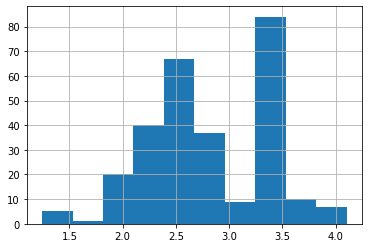

In [12]:
df_t1['T1'].hist()

In [13]:
df_t1.to_csv('./data/T1_oximesters.csv')